<a href="https://colab.research.google.com/github/daniel-hain/bibliometrics_EIST_2021/blob/master/python/BERTopic_EIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERTopic EIST 

* First tryout on EIST topic modelling using BERT an reprentation learning.


## Setup

In [ ]:
# Weird monkey patch
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# When using openai (doesnt work right now)
!pip install --upgrade openai

In [2]:
# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
# Change directory

In [ ]:
# Installing BERTopic
!pip install bertopic

## Data

* Title + Abstracts of all EIST articles up to 02.2023

In [121]:
import os
import pandas as pd
docs = pd.read_csv("https://raw.githubusercontent.com/daniel-hain/bibliometrics_EIST_2021/master/data/data_text.csv")
docs.head()

,UT,PY,text
0,2-S2.0-79957989573,2011,the multi-level perspective on sustainability ...
1,2-S2.0-85060849107,2019,an agenda for sustainability transitions resea...
2,2-S2.0-85009887792,2017,putting the sharing economy into perspective. ...
3,2-S2.0-84941180282,2015,the geography of sustainability transitions: r...
4,2-S2.0-79957999094,2011,engaging with the politics of sustainability t...


# **Topic Modeling**



## Training



In [34]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import KeyBERTInspired
from bertopic.representation import TextGeneration

from sentence_transformers import SentenceTransformer
from transformers.pipelines import pipeline

from hdbscan import HDBSCAN
from umap import UMAP

from sklearn.feature_extraction.text import CountVectorizer

In [122]:
# Own stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

new_stopwords = ["study", "studies", "paper", "insight", "insights", "research", "literature", "framework", "frameworks","rights","reserved" , "study", "studies", "these", "this", "paper", "result", "model", "approach", "article", "author", "method", "understand", "focus", "examine", "aim", "argue", "identify",
          "increase", "datum", "potential", "explore", "include", "issue", "propose", "address", "apply", "require", "analyse", "relate", "finding",
          "analyze", "discuss", "contribute", "publish", "involve", "draw", "lead", "exist", "set", "reduce", "create", "form", "explain", "play",
          "affect", "regard", "associate", "establish", "follow", "conclude", "define", "strong", "attempt", "finally", "elsevier", "offer",
          "taylor", "francis", "copyright", "springer", "wiley", "emerald", "copyright", "b.v"]
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(new_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [123]:
# Some hyperparameters
umap_n_neighbors = 5
umap_n_components = 10
umap_min_dist = 0

hdbscan_min_cluster_size = 10
hdbscan_min_samples = hdbscan_min_cluster_size

# EMBEDDING MODEL:
embedding_model = "allenai-specter"

# DIMENSIONALITY REDUCTION
umap_model = UMAP(n_neighbors=umap_n_neighbors, 
                  n_components=umap_n_components, 
                  min_dist=umap_min_dist, 
                  metric='cosine', 
                  random_state=1337)

# CLUSTERING: resuce min_cluster_size and min_samples
hdbscan_model = HDBSCAN(min_cluster_size=hdbscan_min_cluster_size, 
                        metric='euclidean', 
                        cluster_selection_method='eom', 
                        prediction_data=True, 
                        min_samples=hdbscan_min_samples)

# VECTORIZER: custom vectorizer to get rid of stopwords
vectorizer_model = CountVectorizer(stop_words=stpwrd,
                                   min_df = 10)

# TFIDF Weighting: Weighting model with redued stoppwords
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True,
                                     reduce_frequent_words=True)

In [124]:
import openai
from bertopic.representation import OpenAI

from getpass import getpass # get from: https://docs.google.com/spreadsheets/d/1Zjy7IFRqowBsB1W7vPRQRYcqANOo82LJEvNR22iAsA8/edit#gid=0
#openai.api_key = getpass('Enter OpenAi secret value: ')

In [125]:
## REPRESENTATION MODEL: 
representation_model = MaximalMarginalRelevance(diversity=0.7)
#representation_model = KeyBERTInspired()
#representation_model = OpenAI()

In [126]:
# BEWRTopic: specify all custom models and n_grams
topic_model = BERTopic(nr_topics="auto",
                       language="english", 
                       calculate_probabilities=True,
                       verbose=True, 
                       n_gram_range=(1, 3),
                       #
                       embedding_model=embedding_model, 
                       umap_model=umap_model,
                       hdbscan_model=hdbscan_model, 
                       vectorizer_model=vectorizer_model,
                       ctfidf_model=ctfidf_model,
                       representation_model=representation_model)

In [127]:
topics, probs = topic_model.fit_transform(docs.loc[:,'text'])

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

2023-03-14 12:51:59,777 - BERTopic - Transformed documents to Embeddings
2023-03-14 12:52:03,031 - BERTopic - Reduced dimensionality
2023-03-14 12:52:03,110 - BERTopic - Clustered reduced embeddings
2023-03-14 12:52:04,695 - BERTopic - Reduced number of topics from 14 to 14


## Extracting Topics
* After fitting our model, we can start by looking at the results. 
* Typically, we look at the most frequent topics first as they best represent the collection of documents. 
* -1 refers to all outliers and should typically be ignored. 

In [128]:
freq = topic_model.get_topic_info(); freq.head(50)

,Topic,Count,Name
0,-1,127,-1_institutional_work_financial_sector
1,0,208,0_field_governance_change_attention
2,1,70,1_political_power_european_actors
3,2,69,2_business_learning_firms_niche
4,3,27,3_regime_public_knowledge_attention
5,4,24,4_innovation_knowledge_barriers_within
6,5,24,5_technological_business_sectors_firms
7,6,18,6_financial_economy_efficiency_carbon
8,7,17,7_markets_network_learning_government
9,8,16,8_impacts_risks_low_emissions


## Attributes

* There are a number of attributes that you can access after having trained your BERTopic model:


| Attribute | Description |
|------------------------|---------------------------------------------------------------------------------------------|
| topics_               | The topics that are generated for each document after training or updating the topic model. |
| probabilities_ | The probabilities that are generated for each document if HDBSCAN is used. |
| topic_sizes_           | The size of each topic                                                                      |
| topic_mapper_          | A class for tracking topics and their mappings anytime they are merged/reduced.             |
| topic_representations_ | The top *n* terms per topic and their respective c-TF-IDF values.                             |
| c_tf_idf_              | The topic-term matrix as calculated through c-TF-IDF.                                       |
| topic_labels_          | The default labels for each topic.                                                          |
| custom_labels_         | Custom labels for each topic as generated through `.set_topic_labels`.                                                               |
| topic_embeddings_      | The embeddings for each topic if `embedding_model` was used.                                                              |
| representative_docs_   | The representative documents for each topic if HDBSCAN is used.                                                |

For example, to access the predicted topics for the first 10 documents, we simply run the following:

# **Visualization**
* There are several visualization options available in BERTopic, namely the visualization of topics, probabilities and topics over time. 
* Topic modeling is, to a certain extent, quite subjective. * Visualizations help understand the topics that were created. 

## General topic relation

In [129]:
topic_model.visualize_topics()

## Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [130]:
topic_model.visualize_barchart(top_n_topics=50, n_words = 10)

In [131]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

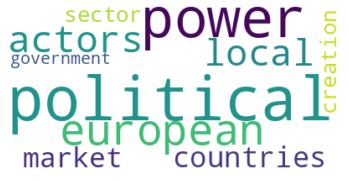

In [132]:
# Show wordcloud
create_wordcloud(topic_model, topic=1)

In [133]:
# Representative docs
rep_doc = topic_model.get_representative_docs()
rep_doc = pd.DataFrame(rep_doc)
rep_doc.T

,0,1,2
-1,beyond the north-south divide: the political e...,framing low-carbon pathways: a discursive anal...,closing the green finance gap – a systems pers...
0,exploring the governance and politics of trans...,the changing landscape of deep transitions: so...,households in sustainability transitions: a sy...
1,mere deployment of renewables or industry form...,explaining inclusivity in energy transitions: ...,trust gaps in energy transitions: japan's nati...
2,user-led innovation in civic energy communitie...,the role of lock-in mechanisms in transition p...,understanding the drivers of fleet emission re...
3,sustainability transitions in the agri-food se...,beyond food for thought – directing sustainabi...,analysing the role of consumers within technol...
4,anchoring of innovations: assessing dutch effo...,power from above? assessing actor-related barr...,zero carbon homes in the uk? analysing the co-...
5,influences of technological and sectoral conte...,china's role in the next phase of the energy t...,the institutional evolution process of the glo...
6,sustainability transition and economic growth ...,"macroeconomics, financial crisis and the envir...",climate change and economic growth enigma: an ...
7,conceptualizing market formation for transform...,using lead market factors to assess the potent...,understanding the limits to forming policy-dri...
8,modelling energy transitions for climate targe...,incorporating social mechanisms in energy deca...,evaluating the global impact of low-carbon ene...


In [140]:
embeddings = topic_model.embedding_model.embed_documents(docs.loc[:,'text'])
pd.DataFrame(embeddings).to_csv('embeddings_specter.csv')

In [135]:
topic_model.visualize_documents(docs.loc[:,'text'], embeddings=embeddings)

## Visualize Topic Hierarchy

* The topics that were created can be hierarchically reduced. 
* In order to understand the potential hierarchical structure of the topics, we can create clusters and visualize how they relate to one another. 
* This might also help selecting an appropriate nr_topics when reducing the number of topics that you have created.

In [141]:
# Calculate Hirarchy
hierarchical_topics = topic_model.hierarchical_topics(docs.loc[:,'text'])

100%|██████████| 12/12 [00:00<00:00, 22.03it/s]


In [142]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [143]:
# Run the visualization with the original embeddings
topic_model.visualize_hierarchical_documents(docs.loc[:,'text'], hierarchical_topics, embeddings=embeddings)

## Topics over time

In [146]:
# Calculate topics over time
topics_over_time = topic_model.topics_over_time(docs.loc[:,'text'],
                                                docs.loc[:,'PY'])

13it [00:07,  1.81it/s]


In [147]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=50)

## Visualize Topic Similarity
Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [148]:
topic_model.visualize_heatmap(n_clusters=5, width=1000, height=1000)

# Optimal: Finetune topics

Only do if you think something should be changes

In [ ]:
# VECTORIZER: custom vectorizer to get rid of stopwords
#vectorizer_model = CountVectorizer(stop_words=stpwrd, min_df = 10)

# TFIDF Weighting: Weighting model with redued stoppwords
#ctfidf_model = ClassTfidfTransformer(bm25_weighting=True,reduce_frequent_words=True)

## REPRESENTATION MODEL: 
# rep_mm = MaximalMarginalRelevance(diversity=0.8)
# rep_kb = KeyBERTInspired()
# rep_oai = OpenAI()
# representation_model = rep_mm # [rep_mm, rep_kb]

# topic_model.update_topics(docs.loc[:,'text'], n_gram_range=(1, 3),
#                          vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model, representation_model=representation_model) 

In [ ]:
# Reduce topics if wanted
# topic_model.reduce_topics(docs, nr_topics=30)

## Visualize Topic Probabilities

- The variable `probabilities` that is returned from `transform()` or `fit_transform()` can  be used to understand how confident BERTopic is that certain topics can be found in a document. 



In [149]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs.loc[:,'text'], calculate_tokens=True)

100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


In [150]:
# Select a document
doc_nr = 102
docs.loc[doc_nr,'text']

'systems of practice and the circular economy: transforming mobile phone product service systems. of late, policy and research attention has increasingly focused on making the circular economy a reality. a key part of this agenda is the creation of sustainable product service systems (spss) that meet consumers’ needs whilst lessening negative environmental impacts. although the spss literature has grown recently, key aspects require further examination. in response, this paper discusses empirical research exploring consumers’ reactions to a novel, hypothetical mobile phone spss, utilizing qualitative methods that included ‘business origami’. it examines consumers’ knowledge about current mobile phone life cycles, and responses to the proposed spss, drawing on a ‘systems of practice’ framework to discuss the potential for significant changes in phone purchase and use. it outlines barriers to alterations in practices, underscoring the centrality that connectivity and data storage now hav

In [151]:
# Get the probability distribution
topic_model.visualize_distribution(probs[doc_nr], min_probability=0.01)

In [152]:
# Visualize the token-level distributions
doc_topic_dist = topic_model.visualize_approximate_distribution(docs.loc[doc_nr,'text'], topic_token_distr[doc_nr])
doc_topic_dist

,systems,of,practice,and,the,circular,economy,transforming,mobile,phone,product,service,systems,of,late,policy,and,research,attention,has,increasingly,focused,on,making,the,circular,economy,reality,key,part,of,this,agenda,is,the,creation,of,sustainable,product,service,systems,spss,that,meet,consumers,needs,whilst,lessening,negative,environmental,impacts,although,the,spss,literature,has,grown,recently,key,aspects,require,further,examination,in,response,this,paper,discusses,empirical,research,exploring,consumers,reactions,to,novel,hypothetical,mobile,phone,spss,utilizing,qualitative,methods,that,included,business,origami,it,examines,consumers,knowledge,about,current,mobile,phone,life,cycles,and,responses,to,the,proposed,spss,drawing,on,systems,of,practice,framework,to,discuss,the,potential,for,significant,changes,in,phone,purchase,and,use,it,outlines,barriers,to,alterations,in,practices,underscoring,the,centrality,that,connectivity,and,data,storage,now,have,in,many,peoples,daily,lives,which,have,for,some,become,clustered,around,the,capabilities,and,accessibility,of,the,mobile,phone
0_field_governance_change_attention,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.104,0.104,0.104,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.109,0.109,0.109,0.109,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1_political_power_european_actors,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.106,0.106,0.106,0.000,0.000,0.000,0.000,0.104,0.208,0.208,0.312,0.208,0.104,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.103,0.206,0.206,0.206,0.103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.102,0.205,0.307,0.307,0.205,0.102,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2_business_learning_firms_niche,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.102,0.204,0.204,0.311,0.209,0.107,0.107,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.150,0.300,0.450,0.579,0.429,0.279,0.129,0.116,0.232,0.232,0.232,0.116,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.100,0.200,0.300,0.300,0.200,0.100,0.000,0.000,0.101,0.101,0.101,0.101,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000

# Work in progress: Manual ChatGTP topic summary:

In [219]:
top_n = 12
n_doc = hdbscan_min_cluster_size

promt_doc_intro = "I want you to act as a professor in social science. I want you to identify the reearch topic following 10 documents (sepperated ending with an '---'), which are titles plus abstacts of scientific journal publications in a journal called 'Environmental Innovation and Societal Transitions'."
# promt_doc = topic_model.get_document_info(docs.loc[:,'text']).sort_values(['Representative_document', 'Probability'],ascending=False).groupby('Topic').head(n_doc)
# promt_doc = promt_doc.groupby('Topic', as_index=False).agg({'Document' : ' --- '.join})

promt_doc = topic_model.get_document_info(docs.loc[:,'text']).sort_values(['Representative_document', 'Probability'],ascending=False).groupby('Topic').head(n_doc)
promt_doc = promt_doc.groupby('Topic', as_index=False).agg({'Document' : ' --- '.join}).query("Topic == @top_n").reset_index().loc[0,'Document']
promt_key_intro = "Now that your recieved the corresponding documents, I will also provide you some keywords describing the topic. They are sepperated with an ','"

promt_key = pd.DataFrame(topic_model.get_topic(top_n))
promt_key = [', '.join(promt_key.loc[:,0])]

promt_final = "Your task is to summarize the topic by a short label of 2-7 words, plus a short description of 3-5 sentences. This summary should highlight the commonality of the documents, considering their content and the provided keywords. It should indicate the main theoretical theme, research framework, context, and implications. It should also indicate if the research in this topic is more quantitative or qualitative, on a macro or micro level, and aimed at theoretical, policy, or industry implications."

print(promt_doc_intro, promt_doc, promt_key_intro, promt_key, promt_final, sep = " \n \n ")

I want you to act as a professor in social science. I want you to identify the reearch topic following 10 documents (sepperated ending with an '---'), which are titles plus abstacts of scientific journal publications in a journal called 'Environmental Innovation and Societal Transitions'. 
 
 theorising the dynamics of collaborative consumption practices: a comparison of peer-to-peer accommodation and cohousing. this article aims to make a contribution to a more nuanced, theory-based interpretation of current dynamics of collaborative consumption (cc). first, i develop my own definition of cc practices, highlighting the engagement of at least two individuals who get involved in direct interaction and make use of the same units of goods and services. this conceptualisation leads me to a compilation of some exemplary cc practices. empirical data shows a very uneven diffusion of these practices in france and in germany. social practice theory (spt) is suggested as very fruitful theoretica

## Results

### Topic 0: Sustainability Transitions and Governance
Description: This topic encompasses a range of empirical and theoretical research that explores the role of social actors, institutions, and governance arrangements in promoting sustainable transitions at different levels of analysis. The literature engages with a variety of local and global sustainability challenges and employs different methodological approaches, including qualitative and quantitative methods. The main research framework used is the Multi-level perspective (MLP) and it has implications for policy and industry actors seeking to promote sustainability transitions.

### Topic 1: Energy Transitions and Political Power
Description: The collection of documents explores the role of political power and actors in the energy transition process in various countries, both developed and emerging. The research highlights the challenges faced by local and community energy initiatives, as well as the impact of advocacy communities and transnational linkages in the creation and restriction of socio-political space for renewable energy. The documents also examine the role of government policies and regulations in shaping the energy sector, including the potential for trust-based deliberative policy-making. Overall, the research is largely qualitative and focused on the policy implications of energy transitions, with a particular emphasis on the political power dynamics that shape the transition process.

### Topic 2: Energy Transitions and Political Power
Description: The collection of documents explores the role of political power and actors in the energy transition process in various countries, both developed and emerging. The research highlights the challenges faced by local and community energy initiatives, as well as the impact of advocacy communities and transnational linkages in the creation and restriction of socio-political space for renewable energy. The documents also examine the role of government policies and regulations in shaping the energy sector, including the potential for trust-based deliberative policy-making. Overall, the research is largely qualitative and focused on the policy implications of energy transitions, with a particular emphasis on the political power dynamics that shape the transition process.

### Topic 3: Sustainability Transitions in Agri-Food Sector
Description: This research topic focuses on the transition towards sustainable agri-food systems, considering the ecological dimensions and the public goods character of biodiversity. The documents highlight the need for cross-sectoral governance, social justice, equity, and inclusion. The research framework employs a mix of qualitative and quantitative methods, studying transitions at the macro and micro level. The implications of this research are relevant for policy and industry, as they provide insights on how to incentivize regime changes, overcome barriers, and support the development of niches for sustainable agri-food systems.

### Topic 4: Barriers to Technological Innovation in Sustainability Transitions
This collection of documents explores the barriers to technological innovation in sustainability transitions, with a focus on the role of design, knowledge, and actor networks. The studies utilize various theoretical perspectives, including the multi-level perspective and innovation systems analysis, to investigate the interactions between technological niches, socio-technical regimes, and policy mixes. The research is largely qualitative and focused on the micro-level, examining case studies in industries such as energy-efficient housing, biorefineries, and sustainable cement. The findings highlight the importance of effective policy design, credible information provision, and collaboration among actors in overcoming barriers to sustainability transitions. The research has implications for policymakers and practitioners seeking to induce system innovation and contribute to sustainability.

### Topic 5: Technological Innovation Systems and Institutional Evolution
Description: The collection of articles investigates the dynamics of technological innovation systems (TIS) and their institutional evolution in the context of emerging clean technology industries. The TIS framework is used to explore the interplay between public and private actors, contextual structures, and innovation processes in sectors such as solar energy, bio-succinate, and photovoltaics. The research highlights the importance of understanding the roles of various actors and contextual factors in driving TIS evolution, as well as the potential for catching up by latecomer countries or firms in formative sectors. The research is mainly qualitative, focused on the macro level, and has implications for both policy and industry.

### Topic 6: Sustainability Transitions in the Financial-Economic System
Description: This research topic explores the sustainability transition in the financial-economic system, focusing on the complex relationship between financial, economic, and environmental factors. The documents analyzed discuss the feasibility of decoupling environmental pressure from aggregate income, strategies for economic growth and green investment, and the role of financial actors in accelerating the transition away from fossil fuels. The research framework is predominantly quantitative, using secondary data on financial investment, policy and governance, and public opinion. The implications of this research are relevant for policymakers, businesses, and investors, as they provide insight into the challenges and opportunities of transitioning to a sustainable economy in a global context.

### Topic 7: Market Formation for Sustainable Transitions
Description: These documents explore the formation of markets as a lever for achieving sustainable transitions. They propose frameworks and models for understanding the dynamic processes of market formation, including the role of actors, networks, and learning. The research draws from a variety of theoretical perspectives, including market formation, transition management, and evolutionary economics. The implications of this research are both theoretical and practical, providing insight for policymakers and industry actors seeking to promote sustainable innovation. The research is primarily qualitative and operates on both macro and micro levels, focusing on the institutional and social dynamics that underpin market formation.

### Topic 8: Energy Transition and Societal Impacts
This collection focuses on the transition to a low-carbon energy-based regime and its societal impacts. The research is predominantly quantitative and employs various modelling techniques to examine the impacts, risks, and opportunities associated with the transition. The main theoretical framework is the socio-technical approach, which recognizes the interdependence between technological, social, and economic factors. The context of the research is mainly European, with a focus on the UK, Ireland, Greece, and Italy. The implications of this research are relevant for policymakers, industry stakeholders, and society at large, as they provide insights into the challenges and opportunities of achieving a sustainable energy future.

### Topic 9: Diffusion of Environmental Innovations in European Countries
Description: This topic focuses on the diffusion of environmental innovations across different sectors and countries in Europe. It includes research on the driving and inhibiting factors of diffusion, the impact of environmental innovation on firms' financial performance and operational efficiency, and the determinants of eco-innovation activities in different European countries. The research is primarily quantitative and aims to provide insights for policymakers and practitioners in designing effective sector-specific transition policies. The theoretical foundation of this topic is primarily based on resource-based and institutional theories, and the prevailing effects identified are those of regulations and market pull factors.

### Topic 10: Innovation in the Wind Energy Sector
Description: These documents explore innovation in the wind energy sector from various perspectives. The research focuses on the technological innovation system (TIS) approach and examines the regional and international dimensions of innovation systems. The documents cover the topics of policy mixes, investor characteristics, offshore oil and gas firms' involvement in offshore wind, and the innovation strategies of Chinese and European wind turbine firms. The research is primarily qualitative and aims to provide theoretical and policy implications for promoting the transition to renewable energy. The main themes include the role of innovation in supporting the growth of the wind energy sector, the importance of regional and international networks, and the need for tailored policies to encourage investment and promote innovation.

### Topic 11: Transition Risks in Climate Governance
Description: The documents examine the risks and opportunities associated with transitioning to a low-carbon economy, focusing on the role of stakeholders, policies, and governance at local and national levels. The studies employ a mix of quantitative and qualitative methods to assess the challenges of decarbonization, highlighting the need for integrated and adaptive policy innovations that account for political, economic, social, and environmental risks. The research is mainly aimed at policy and industry implications, and it operates at a macro level, analyzing national and supranational jurisdictions. The theoretical theme revolves around the trade-off between incremental and transformational change, as well as the need to bridge the gap between physical requirements and societal support for action.

### Topic 12: Collaborative Consumption Dynamics
Description: These articles explore the dynamics of collaborative consumption practices, including peer-to-peer accommodation, cohousing, and energy-saving smart home technologies. Social practice theory is used to explain the diverging diffusion of these practices, while netnographic studies analyze the user interface and design of collaborative consumption platforms. Other articles investigate the motivations for intended sharing economy participation and the impact of sustainability framings of accommodation sharing. Theoretical frameworks, such as the diffusion of innovations theory and framing theory, are applied to examine the social networks and communication behaviors underlying the adoption of these practices. The research in this topic is mainly qualitative and aimed at theoretical and policy implications, focusing on the economic, social, and environmental impacts of the sharing economy.

### Topic 13:

